In [5]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Get feel of audience level

## Show end product

## Goals for this workshop
+ make aware of the power of Deep Learning for Computer Vision.
+ make aware of the tools available.
+ show how to use some of them.
+ show how to collect data, train and deploy model.
+ No theory! But it is important.
+ make aware of workflow
+ make aware of challenges

# Computer Vision Pipeline

## Setting up environemnt

+ Comment on hardware (cloud vs gpu)
+ [Kaggle Kernels](https://www.kaggle.com/kernels)
+ [Google Colab](https://colab.research.google.com/notebooks/) 
+ git
+ Download [Anaconda](https://www.anaconda.com/download/)
    - to use jupyter notebook/lab
+ virtual environment:
    - `conda create [myenv]`
    - `conda activate [myenv]`
    - `conda install [package]`
    - `jupyter lab`
+ comment of DL frameworks:
    - keras + tf
    - pytorch + [fastai](http://www.fast.ai/)
+ fastai setup:
    - `git clone https://github.com/fastai/fastai.git`
    - `cd fastai`
    - `conda env update (-f environment-cpu.yml)`
    - `conda activate fastai(-cpu)`
    - `python -m ipykernel install --user --name fastai --display-name "Python (fastai)"`
    - copy fastai/fastai to working directory

+ other libs to install?

## Collecting Images

+ [Kaggle Datasets](https://www.kaggle.com/datasets)
+ Google search
+ Scrape image libraries: Google Images, Flickr, ...
+ API

I used GET requests from https://www.i-traffic.co.za/map API (show website).

In [160]:
out = requests.get(f'https://www.i-traffic.co.za/api/getevents?key={key}&format={fmt}')

In [1]:
camera_codes = [
    '201B','201C','201D','203','203A','204','205',
    '206','206A','208','209','211','212','213','214',
    '215','216','217'
]

import urllib.request
import time
import datetime
import glob

while(True):
    for code in camera_codes:
        ts = str(datetime.datetime.now().timestamp()).split('.')[0]
        urllib.request.urlretrieve(f'https://www.i-traffic.co.za/map/Cctv/WC%20CCTV%20N2%20{code}--4',
                                   f'images/camera_{code}_{ts}.jpg')
    n_img = len(glob.glob('images/*.jpg'))
    print(f'number of images in `images`: {n_img}')
    time.sleep(60)

How much is enough?

### If the data is not labeled?

+ can be expensive and time consuming
+ depends on nature of task - classification/detection/segmentation
+ crowd source
+ do it yourself

#### Annotation Software
+ many to choose from - https://en.wikipedia.org/wiki/List_of_manual_image_annotation_tools
+ open source vs commercial
+ varies in features - active learning, task types, speed feature, managing users, export format, ...
+ I used [labelImg](https://github.com/tzutalin/labelImg) (show process)

In [19]:
classes = [
    'motorcycle',
    'car', # car, minivan, suv
    'bakkie',
    'van', # delivery van
    'minibus', # taxi
    'bus',
    'truck'
]

classes_txt = '\n'.join(classes).strip('/n')

%store classes_txt > classes.txt

Writing 'classes_txt' (str) to file 'classes.txt'.


Steps I used to get *labelImg* going (see repo README for OS specific instructions):

```
git clone https://github.com/tzutalin/labelImg.git
cd labelImg
conda install pyqt=5
pyrcc5 -o resources.py resources.qrc
python labelImg.py ../images/ ../classes.txt
```

In [85]:
!mkdir to_label

In [ ]:
!mkdir data
!mkdir data/images

In [88]:
all_ims = os.listdir('images')

In [90]:
import numpy as np
np.random.shuffle(all_ims)

In [92]:
for im in all_ims[:20]:
    os.rename(f'images/{im}', f'to_label/{im}')

Move downloaded images already annotated to the directory given to the model.

In [93]:
from pathlib import Path

im_source = Path('to_label')
im_target = Path('data/images')
ann_path = Path('annotations/')

for file in ann_path.iterdir():
    im_old = im_source/f'{file.stem}.jpg'
    if im_old.exists(): im_old.rename(im_target/im_old.name)

To convert the `.xml` files to the more usable `.json` format.

In [ ]:
!python pascal_voc_xml2json.py 

Script adapted from [here](https://github.com/CivilNet/Gemfield/blob/master/src/python/pascal_voc_xml2json/pascal_voc_xml2json.py)

There are advantages to labeling it yourself:
- get to know the data
- appreciate machine learning
- exactly like you want it - full control
- more accurate
- therapeutic

### Train/Validation/Test Split

Idea is to work IRL. Not on training data. Therefore testing data should be as close as possible to the real-world scenario.
For example, if training data only contains sunny days, won't know if it does well on rainy days.

See this [blog](http://www.fast.ai/2017/11/13/validation-sets/)

Take camera ID in consideration.

In [55]:
# code

## Prepare Data for training

In [6]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

/Users/janmarais/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [58]:
PATH = Path('data/')
list(PATH.iterdir())

[PosixPath('data/.DS_Store'),
 PosixPath('data/images'),
 PosixPath('data/instances.json')]

In [95]:
trn_j = json.load((PATH/'instances.json').open())
trn_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [96]:
IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations', 'categories']
trn_j[IMAGES][:5]

[{'id': 1,
  'file_name': 'camera_201B_1535455988.jpg',
  'width': 310,
  'height': 235},
 {'id': 2,
  'file_name': 'camera_201B_1535456259.jpg',
  'width': 310,
  'height': 235},
 {'id': 3,
  'file_name': 'camera_201B_1535457769.jpg',
  'width': 310,
  'height': 235},
 {'id': 4,
  'file_name': 'camera_201B_1535458315.jpg',
  'width': 310,
  'height': 235},
 {'id': 5,
  'file_name': 'camera_201B_1535459023.jpg',
  'width': 310,
  'height': 235}]

In [97]:
trn_j[ANNOTATIONS][:2]

[{'segmentation': [[87, 54, 87, 100, 134, 100, 134, 54]],
  'area': 2162,
  'iscrowd': 0,
  'ignore': 0,
  'image_id': 1,
  'bbox': [87, 54, 47, 46],
  'category_id': 1,
  'id': 1},
 {'segmentation': [[175, 48, 175, 76, 211, 76, 211, 48]],
  'area': 1008,
  'iscrowd': 0,
  'ignore': 0,
  'image_id': 1,
  'bbox': [175, 48, 36, 28],
  'category_id': 2,
  'id': 2}]

In [98]:
trn_j[CATEGORIES]

[{'supercategory': 'none', 'id': 1, 'name': 'van'},
 {'supercategory': 'none', 'id': 2, 'name': 'bakkie'},
 {'supercategory': 'none', 'id': 3, 'name': 'car'},
 {'supercategory': 'none', 'id': 4, 'name': 'minibus'},
 {'supercategory': 'none', 'id': 5, 'name': 'bus'},
 {'supercategory': 'none', 'id': 6, 'name': 'truck'},
 {'supercategory': 'none', 'id': 7, 'name': 'motorcycle'}]

In [99]:
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'

cats = {o[ID]:o['name'] for o in trn_j[CATEGORIES]}
trn_fns = {o[ID]:o[FILE_NAME] for o in trn_j[IMAGES]}
trn_ids = [o[ID] for o in trn_j[IMAGES]]

In [100]:
IMG_PATH = PATH/'images'

In [101]:
list(IMG_PATH.iterdir())[:5]

[PosixPath('data/images/camera_201B_1535455988.jpg'),
 PosixPath('data/images/camera_201B_1535456259.jpg'),
 PosixPath('data/images/camera_201B_1535457769.jpg'),
 PosixPath('data/images/camera_201B_1535459023.jpg'),
 PosixPath('data/images/camera_201B_1535456462.jpg')]

In [102]:
im0_d = trn_j[IMAGES][0]
im0_d[FILE_NAME],im0_d[ID]

('camera_201B_1535455988.jpg', 1)

In [103]:
def hw_bb(bb): return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])

trn_anno = collections.defaultdict(lambda:[])
for o in trn_j[ANNOTATIONS]:
    if not o['ignore']:
        bb = o[BBOX]
        bb = hw_bb(bb)
        trn_anno[o[IMG_ID]].append((bb,o[CAT_ID]))
        
len(trn_anno)

79

In [68]:
im_a = trn_anno[im0_d[ID]]; im_a

[(array([ 54,  87,  99, 133]), 1),
 (array([ 48, 175,  75, 210]), 2),
 (array([35, 76, 52, 95]), 3),
 (array([ 16, 147,  31, 161]), 2),
 (array([  9, 164,  22, 178]), 2)]

In [69]:
im0_a = im_a[0]; im0_a

(array([ 54,  87,  99, 133]), 1)

In [70]:
cats[1]

'van'

In [71]:
trn_anno[17]

[(array([47, 71, 66, 92]), 3),
 (array([ 50, 107,  69, 128]), 2),
 (array([ 20, 155,  31, 168]), 3),
 (array([ 11,  89,  22, 102]), 3),
 (array([ 12, 108,  22, 121]), 6),
 (array([ 14, 135,  22, 146]), 3),
 (array([  6, 121,  14, 134]), 3),
 (array([  3, 153,   9, 169]), 3)]

In [72]:
cats[2], cats[3]

('bakkie', 'car')

In [73]:
bb_voc = [155, 96, 196, 174]
bb_fastai = hw_bb(bb_voc)

In [74]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

In [75]:
f'expected: {bb_voc}, actual: {bb_hw(bb_fastai)}'

'expected: [155, 96, 196, 174], actual: [155  96 196 174]'

In [76]:
im = open_image(IMG_PATH/im0_d[FILE_NAME])

In [77]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [78]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

`*` is the "splat" operator: It takes a list as input, and expands it into actual positional arguments in the function call.

In [79]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [80]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

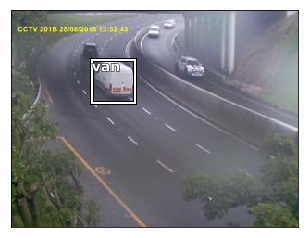

In [81]:
ax = show_img(im)
b = bb_hw(im0_a[0])
draw_rect(ax, b)
draw_text(ax, b[:2], cats[im0_a[1]])

In [82]:
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

In [83]:
def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    print(im.shape)
    draw_im(im, im_a)

(235, 310, 3)


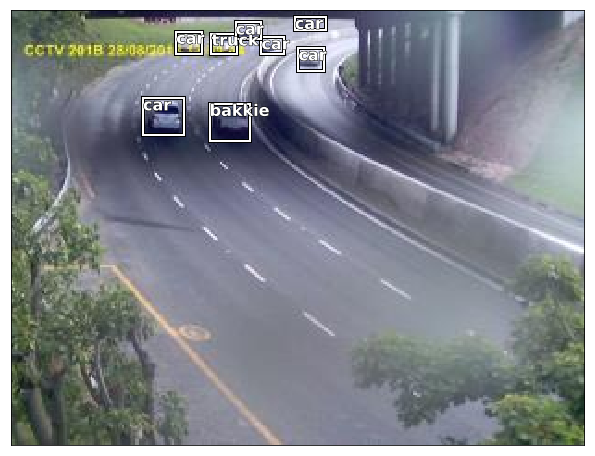

In [84]:
draw_idx(17)

## Bus Classifier

## Multi-Label Vehicle Classification

## Vehicle Detection

## Model building

### Network Architecture
### Training
#### Data Augmentation
#### Transfer Learning

## Testing/Validation

## Deploying